In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import glob
import cv2

from tools import config
from tools.ensemble_sugeno_fuzzy_integral import ensemble

In [3]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

testGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 2001 images belonging to 6 classes.


In [5]:
vgg = load_model(os.path.sep.join([config.OUTPUT_PATH, "vgg.model"]))
resnet = load_model(os.path.sep.join([config.OUTPUT_PATH, "resnet101.model"]))
inception = load_model(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.model"]))

In [6]:
vgg_predictions = list()
resnet_predictions = list()
inception_predictions = list()
    
for path in testGen.filepaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    
    vgg_pred = vgg.predict(image)
    resnet_pred = resnet.predict(image)
    inception_pred = inception.predict(image)
    
    vgg_predictions.append(vgg_pred[0])
    resnet_predictions.append(resnet_pred[0])
    inception_predictions.append(inception_pred[0])

In [18]:
vgg_report = classification_report(
    testGen.classes, [arr.argmax(axis=0) for arr in vgg_predictions],
    target_names=config.CLASSES, output_dict=True
)

resnet_report = classification_report(
    testGen.classes, [arr.argmax(axis=0) for arr in resnet_predictions],
    target_names=config.CLASSES, output_dict=True
)

inception_report = classification_report(
    testGen.classes, [arr.argmax(axis=0) for arr in inception_predictions],
    target_names=config.CLASSES, output_dict=True
)

In [20]:
accuracy_models = {
    "resnet101" : resnet_report['accuracy'],
    "vgg16" : vgg_report['accuracy'],
    "inceptionv3" : inception_report['accuracy']
}

with open(os.path.sep.join([config.OUTPUT_PATH, "accuracy_models.pkl"]), "wb") as f:
    pickle.dump(accuracy_models, f)

In [21]:
with open(os.path.sep.join([config.OUTPUT_PATH, "accuracy_models.pkl"]), "rb") as f:
    accuracy_models = pickle.load(f)
    
measures = [accuracy_models["vgg16"], accuracy_models["resnet101"], accuracy_models["inceptionv3"]]

In [24]:
final_predictions = list()
for i in range(len(testGen.classes)):
    pred = ensemble(measures, vgg_predictions[i], resnet_predictions[i], inception_predictions[i])
    final_predictions.append(pred)
    
print(classification_report(testGen.classes,
    final_predictions, target_names=testGen.class_indices))

              precision    recall  f1-score   support

        open       0.99      0.99      0.99       388
       short       0.95      1.00      0.97       301
    mousebit       0.98      0.98      0.98       393
        spur       1.00      0.96      0.98       325
      copper       1.00      1.00      1.00       294
    pin-hole       0.99      0.99      0.99       300

    accuracy                           0.99      2001
   macro avg       0.99      0.99      0.99      2001
weighted avg       0.99      0.99      0.99      2001



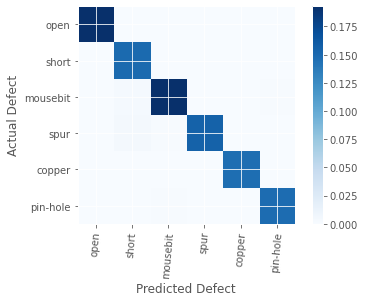

In [25]:
cm = confusion_matrix(testGen.classes, final_predictions, normalize='all')
plt.style.use("ggplot")
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))
plt.xticks(tick_marks, testGen.class_indices, rotation=85)
plt.yticks(tick_marks, testGen.class_indices)
plt.xlabel('Predicted Defect')
plt.ylabel('Actual Defect')
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "ensemble_confusion_matrix.png"]))
plt.show()

In [74]:
def predict_by_ensemble(*images):
    with open(os.path.sep.join([config.OUTPUT_PATH, "accuracy_models.pkl"]), "rb") as f:
        accuracy_models = pickle.load(f)
    measures = [accuracy_models["vgg16"], accuracy_models["resnet101"], accuracy_models["inceptionv3"]]
    
    final_predictions = list()
    for image in images:
        try:
            image = cv2.resize(image, (224, 224))
            image = np.expand_dims(image, axis=0)
        except:
            final_predictions.append(-1)
            continue
        
        vgg_pred = vgg.predict(image)[0]
        resnet_pred = resnet.predict(image)[0]
        inception_pred = inception.predict(image)[0]
        
        if (vgg_pred.argmax(axis=0) < 0.6 and
            (resnet_pred.argmax(axis=0) < 0.6 or
            inception_pred.argmax(axis=0) < 0.6)):
            
            final_predictions.append(-1)
            continue
            
        pred = ensemble(measures, vgg_pred, resnet_pred, inception_pred)
        final_predictions.append(pred)
        
    return final_predictions
    

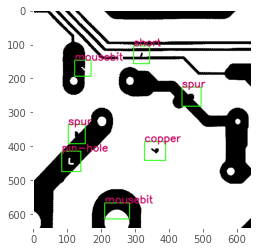

In [75]:
img_temp = cv2.imread(f"{config.DATASET_PATH}/group00041/00041/00041143_temp.jpg")
img_test = cv2.imread(f"{config.DATASET_PATH}/group00041/00041/00041143_test.jpg")
sub_img_temp = cv2.subtract(img_temp, img_test)
sub_img_test = cv2.subtract(img_test, img_temp)

gray_sub_img_temp = cv2.cvtColor(sub_img_temp, cv2.COLOR_BGR2GRAY)
gray_sub_img_test = cv2.cvtColor(sub_img_test, cv2.COLOR_BGR2GRAY)
_, treshold_mask_temp = cv2.threshold(gray_sub_img_temp, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
_, treshold_mask_test = cv2.threshold(gray_sub_img_test, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

img_temp[treshold_mask_temp != 255] = [0, 0, 255]
img_temp[treshold_mask_test != 255] = [0, 255, 0]

original = img_temp.copy()
hsv = cv2.cvtColor(img_temp, cv2.COLOR_BGR2HSV)

mask1 = cv2.inRange(hsv, (0, 150, 50), (10,255,255))
mask2 = cv2.inRange(hsv, (36, 0, 0), (70, 255,255))
mask = cv2.bitwise_or(mask1, mask2)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))   
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
offset = 20

gray_sub_img = cv2.cvtColor(img_temp, cv2.COLOR_BGR2GRAY)
_, treshold_mask = cv2.threshold(gray_sub_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
original[treshold_mask == 255] = [0, 0, 0]
original[treshold_mask != 255] = [255, 255, 255]

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    ROI = original[y - offset:y + h + offset, x - offset:x + w + offset]
    pred = predict_by_ensemble(ROI)
    if pred[0] != -1:
        cv2.rectangle(original, (x - offset, y - offset), (x + w + offset, y + h + offset), (36, 255, 10), 2)
        cv2.putText(original, config.CLASSES[pred[0]], (x - offset, y - offset), 0, 1, 
                (200, 10, 100),2, cv2.LINE_AA)

plt.grid(False)
plt.imshow(original)